<a href="https://colab.research.google.com/github/Pengyu-gis/Historical-Aerial-Photos/blob/main/GT_historical_aerial_Black_White.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio

In [2]:
import rasterio
import numpy as np
import os
from matplotlib import pyplot as plt

#Step 1: Load the Aerial TIFF Files


Image Shape (Bands, Height, Width): (3, 8859, 8835)
Georeferencing Profile: {'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 256.0, 'width': 8835, 'height': 8859, 'count': 3, 'crs': CRS.from_epsg(3857), 'transform': Affine(1.280361999999932, 0.0, -8899755.23105893,
       0.0, -1.2803620000000113, 3872598.7068046583), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'interleave': 'pixel'}


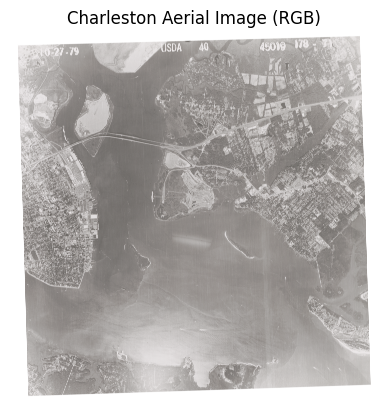

In [9]:
tiff_path = '/content/drive/MyDrive/aerial_photos/45019_1979_0178_0071_x_24.tif'  # Replace with your TIFF file path

# Load TIFF using rasterio
with rasterio.open(tiff_path) as src:
    image_array = src.read()  # Read all bands (returns a NumPy array)
    profile = src.profile  # Store georeferencing information

# Check some details
print(f"Image Shape (Bands, Height, Width): {image_array.shape}")
print(f"Georeferencing Profile: {profile}")

# Visualize the first three bands as an RGB image
if image_array.shape[0] >= 3:  # Ensure there are at least three bands
    plt.imshow(np.moveaxis(image_array[:3], 0, -1))  # Convert from (Bands, H, W) to (H, W, Bands)
    plt.title("Charleston Aerial Image (RGB)")
    plt.axis('off')
    plt.show()


# Step 2: Load the GeoJSON File for Charleston, SC


In [3]:
import geopandas as gpd

       release  capture_dates_range  \
57476        2  3/23/2019-3/27/2019   
57520        2  3/23/2019-3/27/2019   
57524        2  3/23/2019-3/27/2019   
57525        2  3/23/2019-3/27/2019   
57526        2  3/23/2019-3/27/2019   

                                                geometry  
57476  POLYGON ((-79.79987 32.85213, -79.79983 32.852...  
57520  POLYGON ((-79.80085 32.8267, -79.8008 32.82671...  
57524  POLYGON ((-79.80124 32.86446, -79.80114 32.864...  
57525  POLYGON ((-79.80128 32.78108, -79.80124 32.781...  
57526  POLYGON ((-79.80134 32.88563, -79.80126 32.885...  


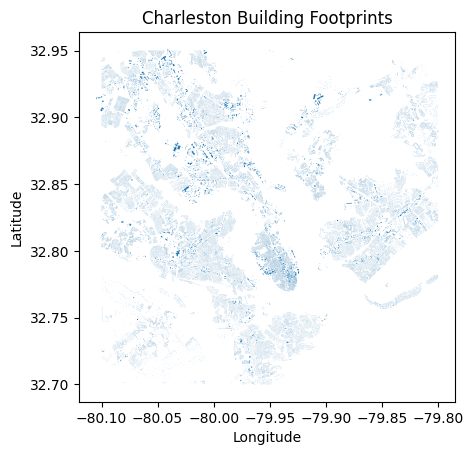

In [4]:
# Load the entire South Carolina GeoJSON
geojson_path = '/content/drive/MyDrive/aerial_photos/SouthCarolina.geojson'
gdf_sc = gpd.read_file(geojson_path)

# Define the bounding box for Charleston (example coordinates, adjust as necessary)
charleston_bbox = {
    "minx": -80.10,  # Replace with correct value
    "miny": 32.70,   # Replace with correct value
    "maxx": -79.80,  # Replace with correct value
    "maxy": 32.95    # Replace with correct value
}

# Filter buildings within the bounding box for Charleston
gdf_charleston = gdf_sc.cx[charleston_bbox["minx"]:charleston_bbox["maxx"], charleston_bbox["miny"]:charleston_bbox["maxy"]]

# Save the filtered GeoDataFrame to a new GeoJSON (optional)
gdf_charleston.to_file('/content/Charleston.geojson', driver='GeoJSON')

# Check the first few records to confirm extraction
print(gdf_charleston.head())

# Plot the filtered footprints
gdf_charleston.plot()
plt.title("Charleston Building Footprints")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [5]:
# Extract bounding boxes from GeoDataFrame
bounding_boxes = gdf_charleston.geometry.bounds

# Convert to a list of [x_min, y_min, x_max, y_max] for model training
bbox_list = bounding_boxes.values.tolist()

# Display sample bounding boxes
print("Sample Bounding Boxes:", bbox_list[:5])


Sample Bounding Boxes: [[-79.800091, 32.852131, -79.799826, 32.852314], [-79.800925, 32.826693, -79.800733, 32.826866], [-79.801235, 32.86446, -79.801094, 32.864618], [-79.801353, 32.78103, -79.801147, 32.781192], [-79.801489, 32.885631, -79.801263, 32.885823]]


# Step 3 Align TIFF Images with Bounding Boxes

In [6]:
from rasterio.windows import Window
import torch
from torchvision import transforms

In [7]:
# Load Charleston GeoJSON file with bounding boxes
geojson_path = '/content/Charleston.geojson'
gdf_charleston = gpd.read_file(geojson_path)

# Extract bounding boxes as [x_min, y_min, x_max, y_max]
bounding_boxes = gdf_charleston.geometry.bounds.values.tolist()

# Display the number of bounding boxes found
print(f"Number of bounding boxes: {len(bounding_boxes)}")


Number of bounding boxes: 122362


In [10]:
import geopandas as gpd
import rasterio
from shapely.geometry import box  # Import box from shapely.geometry

with rasterio.open(tiff_path) as src:
    # Get the bounds of the TIFF image
    tiff_bounds = src.bounds
    print(f"TIFF Bounds: {tiff_bounds}")

    # Convert bounds to a GeoPandas compatible format (bounding box)
    # Use box from shapely.geometry to create the polygon
    bbox = gpd.GeoDataFrame(index=[0], crs=src.crs, geometry=[box(tiff_bounds.left, tiff_bounds.bottom, tiff_bounds.right, tiff_bounds.top)])

# Ensure GeoJSON is in the same CRS as TIFF
if gdf_sc.crs != bbox.crs:
    gdf_sc = gdf_sc.to_crs(bbox.crs)

# Spatially filter GeoJSON to only include buildings within the TIFF extent
# Use 'predicate' instead of the deprecated 'op' argument
gdf_filtered = gpd.sjoin(gdf_sc, bbox, how="inner", predicate="intersects")

# Save filtered GeoDataFrame to a new GeoJSON (optional)
gdf_filtered.to_file('/content/Charleston_filtered.geojson', driver='GeoJSON')

# Check the number of buildings in the filtered dataset
print(f"Number of buildings within the TIFF bounds: {len(gdf_filtered)}")

TIFF Bounds: BoundingBox(left=-8899755.23105893, bottom=3861255.979846658, right=-8888443.23278893, top=3872598.7068046583)
Number of buildings within the TIFF bounds: 17739


In [11]:
# Extract bounding boxes from filtered GeoDataFrame
bounding_boxes = gdf_filtered.geometry.bounds.values.tolist()

# Display the number of bounding boxes found
print(f"Number of bounding boxes in filtered data: {len(bounding_boxes)}")


Number of bounding boxes in filtered data: 17739


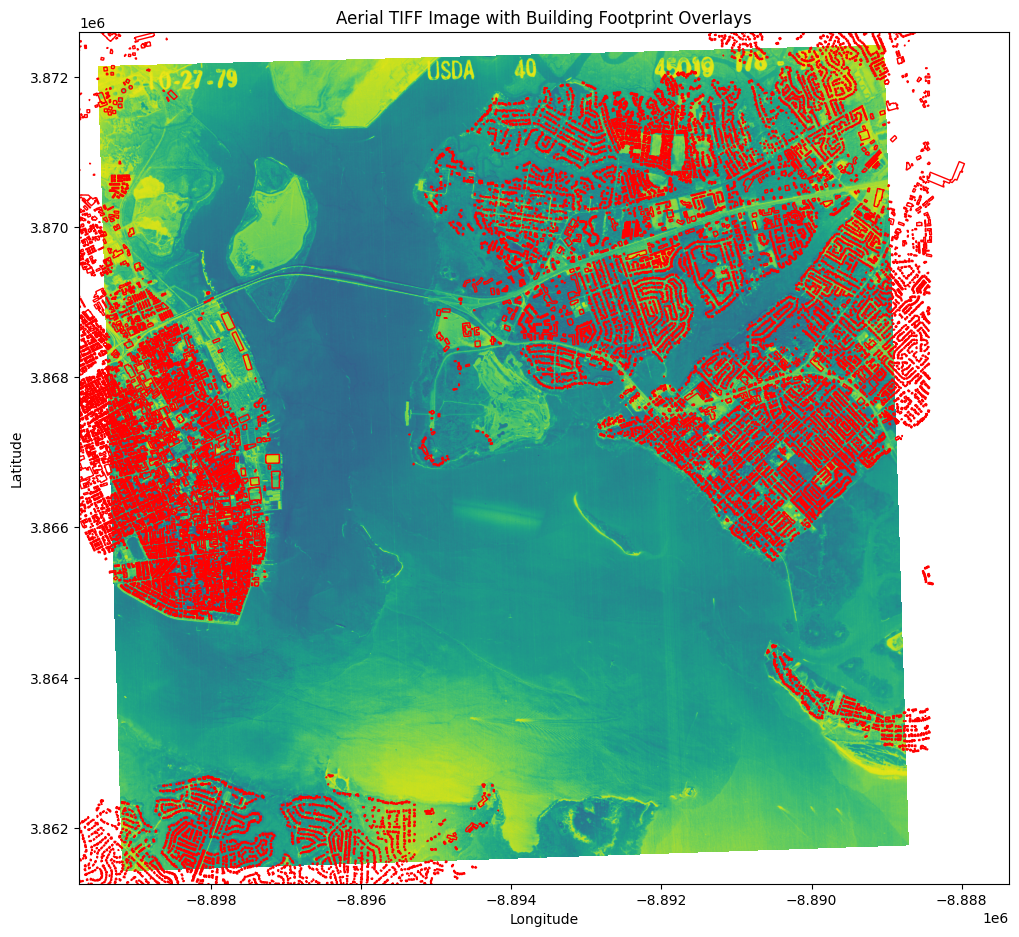

In [12]:
from rasterio.plot import show
# Plot the TIFF image and overlay the building footprints
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the TIFF image using rasterio
with rasterio.open(tiff_path) as src:
    show(src, ax=ax, title="Aerial Image with Building Footprints")

# Overlay the building footprints
gdf_filtered.boundary.plot(ax=ax, color='red', linewidth=1)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Aerial TIFF Image with Building Footprint Overlays")
plt.show()


# Step 4 Clip the TIFF Image into Small Patches

In [14]:
# Define the patch size
patch_size = 1024  # Size of each patch (512x512 pixels)

with rasterio.open(tiff_path) as src:
    # Get the image width and height
    img_width, img_height = src.width, src.height

    # Create a list of patches (defined by window coordinates)
    patches = []
    for row_start in range(0, img_height, patch_size):
        for col_start in range(0, img_width, patch_size):
            row_end = min(row_start + patch_size, img_height)
            col_end = min(col_start + patch_size, img_width)
            window = Window(col_start, row_start, col_end - col_start, row_end - row_start)
            patches.append(window)

    print(f"Number of patches: {len(patches)}")


Number of patches: 81


In [16]:
from shapely.geometry import box

# Function to calculate footprint density for each patch
patch_footprints = []

with rasterio.open(tiff_path) as src:
    for window in patches:
        # Get the bounds of the patch
        bounds = rasterio.windows.bounds(window, src.transform)

        # Access the bounds as a tuple (minx, miny, maxx, maxy)
        minx, miny, maxx, maxy = bounds

        # Create a bounding box geometry for the patch using the tuple values
        patch_box = box(minx, miny, maxx, maxy)

        # Filter the building footprints that intersect with this bounding box
        gdf_patch = gdf_sc[gdf_sc.intersects(patch_box)]

        # Count the number of footprints in this patch
        footprint_count = len(gdf_patch)

        # Store information about this patch if it contains footprints
        if footprint_count > 0:
            patch_footprints.append({
                "window": window,
                "footprint_count": footprint_count,
                "bounds": bounds
            })

print(f"Number of patches with footprints: {len(patch_footprints)}")


Number of patches with footprints: 59


In [ ]:
# Set a threshold for selecting high-density patches (e.g., at least 10 footprints)
threshold = 10
selected_patches = [patch for patch in patch_footprints if patch["footprint_count"] >= threshold]

print(f"Number of high-density patches: {len(selected_patches)}")


In [ ]:
import os
import rasterio

# Create directory in Google Drive to store patches
patches_dir = '/content/drive/MyDrive/aerial_photos/aerial_patches'
os.makedirs(patches_dir, exist_ok=True)

# Save high-density patches
with rasterio.open(tiff_path) as src:
    for i, patch in enumerate(selected_patches):
        window = patch["window"]
        bounds = patch["bounds"]

        # Read the patch from the TIFF image
        patch_data = src.read(window=window)
        patch_transform = src.window_transform(window)

        # Define output path
        patch_output_path = os.path.join(patches_dir, f'patch_{i+1}.tif')

        # Save patch as a new TIFF file
        with rasterio.open(
            patch_output_path,
            'w',
            driver='GTiff',
            height=patch_data.shape[1],
            width=patch_data.shape[2],
            count=patch_data.shape[0],
            dtype=patch_data.dtype,
            crs=src.crs,
            transform=patch_transform,
        ) as dst:
            dst.write(patch_data)

        print(f"Saved patch {i+1} with {patch['footprint_count']} footprints to {patch_output_path}")


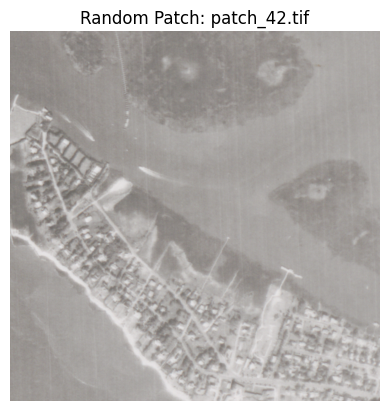

In [21]:
import random

patch_files = [os.path.join(patches_dir, f) for f in os.listdir(patches_dir) if f.endswith('.tif')]

# Select a random patch from the list of saved patches
random_patch_path = random.choice(patch_files)

# Load and visualize the selected patch
with rasterio.open(random_patch_path) as src:
    # Read the first three bands (assuming RGB) if available
    patch_data = src.read([1, 2, 3]) if src.count >= 3 else src.read(1)

    # If the image is grayscale (single band), handle differently
    if patch_data.ndim == 2:
        plt.imshow(patch_data, cmap='gray')
    else:
        plt.imshow(np.moveaxis(patch_data, 0, -1))  # Visualizing in (H, W, Bands) format

    plt.title(f"Random Patch: {os.path.basename(random_patch_path)}")
    plt.axis('off')
    plt.show()
